In [141]:
from dotenv import load_dotenv
import os
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import matplotlib.pyplot as plt

load_dotenv()

True

In [2]:
db_url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/postgres"
engine = create_engine(db_url)


sql_query = """
    SELECT
        time, olr, speed, speeduncapped, freeflow, jamfactor, traversability, day_of_week, is_peak_hour, time_to_traverse, congestion_level, is_anomaly
    FROM diu.traffic_data WHERE day_of_week IS NOT NULL AND name IS NOT NULL;
"""
traffic_data = pd.read_sql(sql_query, engine)

In [3]:
traffic_data

,time,olr,speed,speeduncapped,freeflow,jamfactor,traversability,day_of_week,is_peak_hour,time_to_traverse,congestion_level,is_anomaly
0,2024-12-19 07:44:21.632000+00:00,CD0BEAA5OAYYECTyQQAJBQQCAuQACgUEAqx8APcBANcACQ...,13.888889,13.888889,16.388890,1.4,open,4,True,551.519996,Low,False
1,2024-12-27 20:00:48.505000+00:00,CCoBEAAmJQYWPiT7GQAJBQQBAk8ACgUEAZ8uABVt/NUACQ...,14.444445,14.444445,14.722222,0.1,open,5,False,245.007683,Low,False
2,2024-12-27 17:00:48.359000+00:00,CCkBEAAlJAYGeiT1zQAJBQQAAdYACgUEAKhjAO2iDaEACQ...,35.277780,35.277780,29.166668,0.0,open,5,True,148.166920,Low,False
3,2024-12-27 17:00:48.359000+00:00,CCgBEAAkIwYTOyUAYQAJBQQBAwAACgQDAQsAAAAACgAJBQ...,6.388889,6.388889,10.555556,3.0,open,5,True,1.721739,Moderate,True
4,2024-12-28 02:20:48.509000+00:00,CCkBEAAlJAYXkiTxsQAJBQQAASEACgUEALcaABT0EnkACQ...,23.333334,23.333334,28.611113,2.7,open,6,False,303.042848,Low,False
...,...,...,...,...,...,...,...,...,...,...,...,...
846447,2025-01-07 20:56:48.295000+00:00,CCkBEAAlJAXy/yTqawAJBQQBAisACgUEAdA1ACisGCwACQ...,15.833334,15.833334,16.666668,0.5,open,2,False,650.905236,Low,False
846448,2025-01-07 20:56:48.295000+00:00,CCkBEAAlJAYJBST1CgAJBQQAAVQACgUEAJ9gAA1Q9UIACQ...,31.388890,31.388890,29.166668,0.0,open,2,False,129.631854,Low,False
846449,2025-01-07 20:58:48.320000+00:00,CCkBEAAlJAX/AyT7+gAJBQQBAzIACgUEAoogAAXyAsIACQ...,13.611112,13.611112,12.500000,0.0,open,2,False,96.685708,Low,False
846450,2025-01-07 20:58:48.320000+00:00,CCkBEAAlJAYIjCT2mwAJBQQBA78ACgUEAYl+APpu/gQACQ...,11.111112,11.111112,12.777778,1.3,open,2,False,115.289991,Low,False


In [60]:
tmp_df = traffic_data.copy()
value_counts = tmp_df['olr'].value_counts()
tmp_df = tmp_df[tmp_df['olr'].isin(value_counts[value_counts >= 100].index)]
tmp_df['is_peak_hour'] = tmp_df['is_peak_hour'].astype(int)
tmp_df['is_anomaly'] = tmp_df['is_anomaly'].astype(int)
tmp_df['congestion_level'] = tmp_df['congestion_level'].map({'High': 2, 'Moderate': 1, 'Low': 0})
tmp_df['traversability'] = tmp_df['traversability'].map({'closed': 1, 'open': 0})
tmp_df.loc[tmp_df['traversability'] == 1, 'speed'] = tmp_df.loc[tmp_df['traversability'] == 1, 'speed'].fillna(0)
tmp_df.loc[tmp_df['traversability'] == 1, 'speeduncapped'] = tmp_df.loc[tmp_df['traversability'] == 1, 'speeduncapped'].fillna(0)
tmp_df.loc[tmp_df['traversability'] == 1, 'time_to_traverse'] = tmp_df.loc[tmp_df['traversability'] == 1, 'time_to_traverse'].fillna(0)
tmp_df = tmp_df.dropna()

tmp_df

,time,olr,speed,speeduncapped,freeflow,jamfactor,traversability,day_of_week,is_peak_hour,time_to_traverse,congestion_level,is_anomaly
0,2024-12-19 07:44:21.632000+00:00,CD0BEAA5OAYYECTyQQAJBQQCAuQACgUEAqx8APcBANcACQ...,13.888889,13.888889,16.388890,1.4,0,4,1,551.519996,0,0
1,2024-12-27 20:00:48.505000+00:00,CCoBEAAmJQYWPiT7GQAJBQQBAk8ACgUEAZ8uABVt/NUACQ...,14.444445,14.444445,14.722222,0.1,0,5,0,245.007683,0,0
2,2024-12-27 17:00:48.359000+00:00,CCkBEAAlJAYGeiT1zQAJBQQAAdYACgUEAKhjAO2iDaEACQ...,35.277780,35.277780,29.166668,0.0,0,5,1,148.166920,0,0
3,2024-12-27 17:00:48.359000+00:00,CCgBEAAkIwYTOyUAYQAJBQQBAwAACgQDAQsAAAAACgAJBQ...,6.388889,6.388889,10.555556,3.0,0,5,1,1.721739,1,1
4,2024-12-28 02:20:48.509000+00:00,CCkBEAAlJAYXkiTxsQAJBQQAASEACgUEALcaABT0EnkACQ...,23.333334,23.333334,28.611113,2.7,0,6,0,303.042848,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
846447,2025-01-07 20:56:48.295000+00:00,CCkBEAAlJAXy/yTqawAJBQQBAisACgUEAdA1ACisGCwACQ...,15.833334,15.833334,16.666668,0.5,0,2,0,650.905236,0,0
846448,2025-01-07 20:56:48.295000+00:00,CCkBEAAlJAYJBST1CgAJBQQAAVQACgUEAJ9gAA1Q9UIACQ...,31.388890,31.388890,29.166668,0.0,0,2,0,129.631854,0,0
846449,2025-01-07 20:58:48.320000+00:00,CCkBEAAlJAX/AyT7+gAJBQQBAzIACgUEAoogAAXyAsIACQ...,13.611112,13.611112,12.500000,0.0,0,2,0,96.685708,0,0
846450,2025-01-07 20:58:48.320000+00:00,CCkBEAAlJAYIjCT2mwAJBQQBA78ACgUEAYl+APpu/gQACQ...,11.111112,11.111112,12.777778,1.3,0,2,0,115.289991,0,0


In [159]:
time_series_data = tmp_df.pivot_table(
    index="time",
    columns="olr",
    values=["speeduncapped", "freeflow", "jamfactor", "traversability"],
    aggfunc="mean",
).fillna(-1)

time_series_data.columns = ['_'.join(map(str, col)) for col in time_series_data.columns]
time_series_data

In [160]:
scaler = MinMaxScaler()
time_series_data_normalized = scaler.fit_transform(time_series_data.values.T)

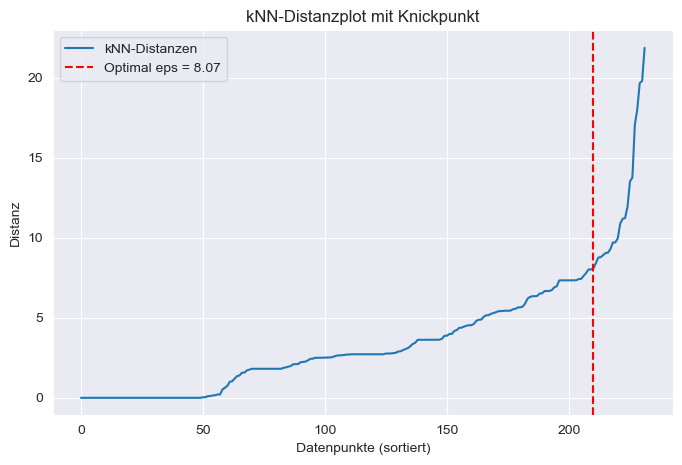

In [185]:
X = time_series_data_normalized

min_samples = 8

nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances[:, -1])

knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee.knee]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(distances, label="kNN-Distanzen")
plt.axvline(x=knee.knee, color="r", linestyle="--", label=f"Optimal eps = {optimal_eps:.2f}")
plt.title("kNN-Distanzplot mit Knickpunkt")
plt.xlabel("Datenpunkte (sortiert)")
plt.ylabel("Distanz")
plt.legend()
plt.show()

In [184]:
X = time_series_data_normalized

# Verschiedene Werte für min_samples testen
min_samples_range = range(2, 15)  # Werte von 3 bis 10 testen

results = []
for min_samples in min_samples_range:
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    distances = np.sort(distances[:, -1])
    
    knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    optimal_eps = distances[knee.knee]
    
    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples).fit(X)
    labels = dbscan.labels_

    # Clusterqualität nur bewerten, wenn es mehr als 1 Cluster gibt
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(X, labels)
        results.append((min_samples, silhouette_avg))

results

[(2, 0.5035549891072004),
 (3, 0.6525735992243328),
 (4, 0.6527270398286721),
 (5, 0.5994007585516814),
 (6, 0.6478634352475258),
 (7, 0.6521757374412934),
 (8, 0.6699635595335167),
 (9, 0.6608069226394245),
 (10, 0.5312235630360632),
 (11, 0.5260994834302445),
 (12, 0.5260994834302445)]

In [188]:
dbscan = DBSCAN(eps=8.07, min_samples=8, metric="euclidean")
labels = dbscan.fit_predict(time_series_data_normalized)

sil_score = silhouette_score(time_series_data_normalized, labels)
sil_score

0.6660759739306363

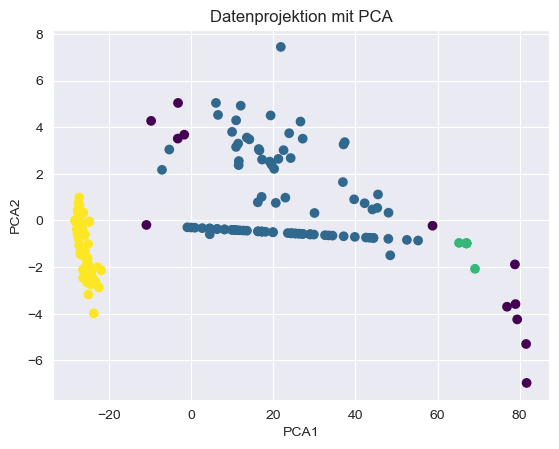

In [189]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(time_series_data_normalized)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap="viridis")
plt.title("Datenprojektion mit PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

In [190]:
os.environ["OMP_NUM_THREADS"] = "2"
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
labels = kmeans.fit_predict(time_series_data_normalized)

sil_score = silhouette_score(time_series_data_normalized, labels)
sil_score

C:\Users\dgojn\anaconda3\envs\Datenanalyse-in-Unternehmen\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.7022596153909844

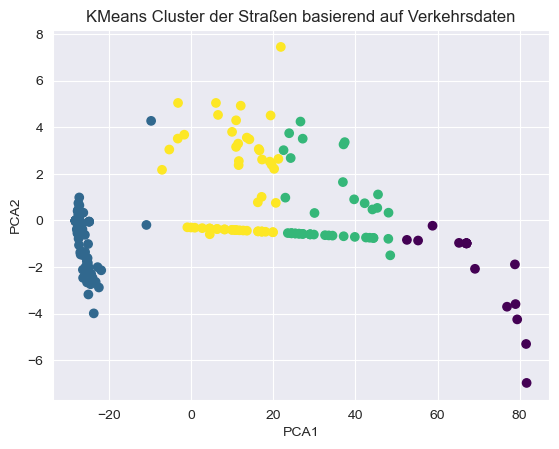

In [191]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(time_series_data_normalized)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap="viridis")
plt.title("KMeans Cluster der Straßen basierend auf Verkehrsdaten")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()